# Library

In [1]:
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold
import matplotlib.pyplot as plt
import pickle

# 데이터 전처리

In [2]:
data = pd.read_csv("./P3/data.csv")

Gender = data.Gender.map({'Boy':1, 'Girl':0})
Age = data.Age.map({'1-5':0, '6-10':1, '11-15':2, '16-20':3, '21-25':4, '26-30':5})
Education_Level = data['Education Level'].map({'School':0,'College':1,'University':2})
Institution_Type = data['Institution Type'].map({'Non Government':0,'Government':1})
IT_Student = data['IT Student'].map({'Yes':1, 'No':0})
Location = data.Location.map({'Yes':1, 'No':0})
Load_shedding = data['Load-shedding'].map({'High':1, 'Low':0})
Financial_Condition = data['Financial Condition'].map({'Poor':0,'Mid':1,'Rich':2})
Internet_Type = data['Internet Type'].map({'Mobile Data':1, 'Wifi':0})
Network_Type = data['Network Type'].map({'2G':0,'3G':1,'4G':2})
Class_Duration = data['Class Duration'].map({'0':0,'1-3':1,'3-6':2})
Self_Lms = data['Self Lms'].map({'Yes':1,'No':0})
Device = data.Device.map({'Mobile':0, 'Tab':1, 'Computer':2})
Adaptivity_Level = data['Adaptivity Level'].map({'Low':0, 'Moderate':1, 'High':2})

In [15]:
X_data = pd.concat([Gender,Age,Education_Level,Institution_Type,IT_Student,Location,Load_shedding,
                Financial_Condition,Internet_Type,Network_Type,Class_Duration,Self_Lms,Device], axis=1)
Y_data = Adaptivity_Level
train_X = X_data.iloc[:-300]
train_Y = Y_data.iloc[:-300]
valid_X = X_data.iloc[-300:]
valid_Y = Y_data.iloc[-300:]
Full_data = pd.concat([X_data, Y_data],axis=1)

# EDA

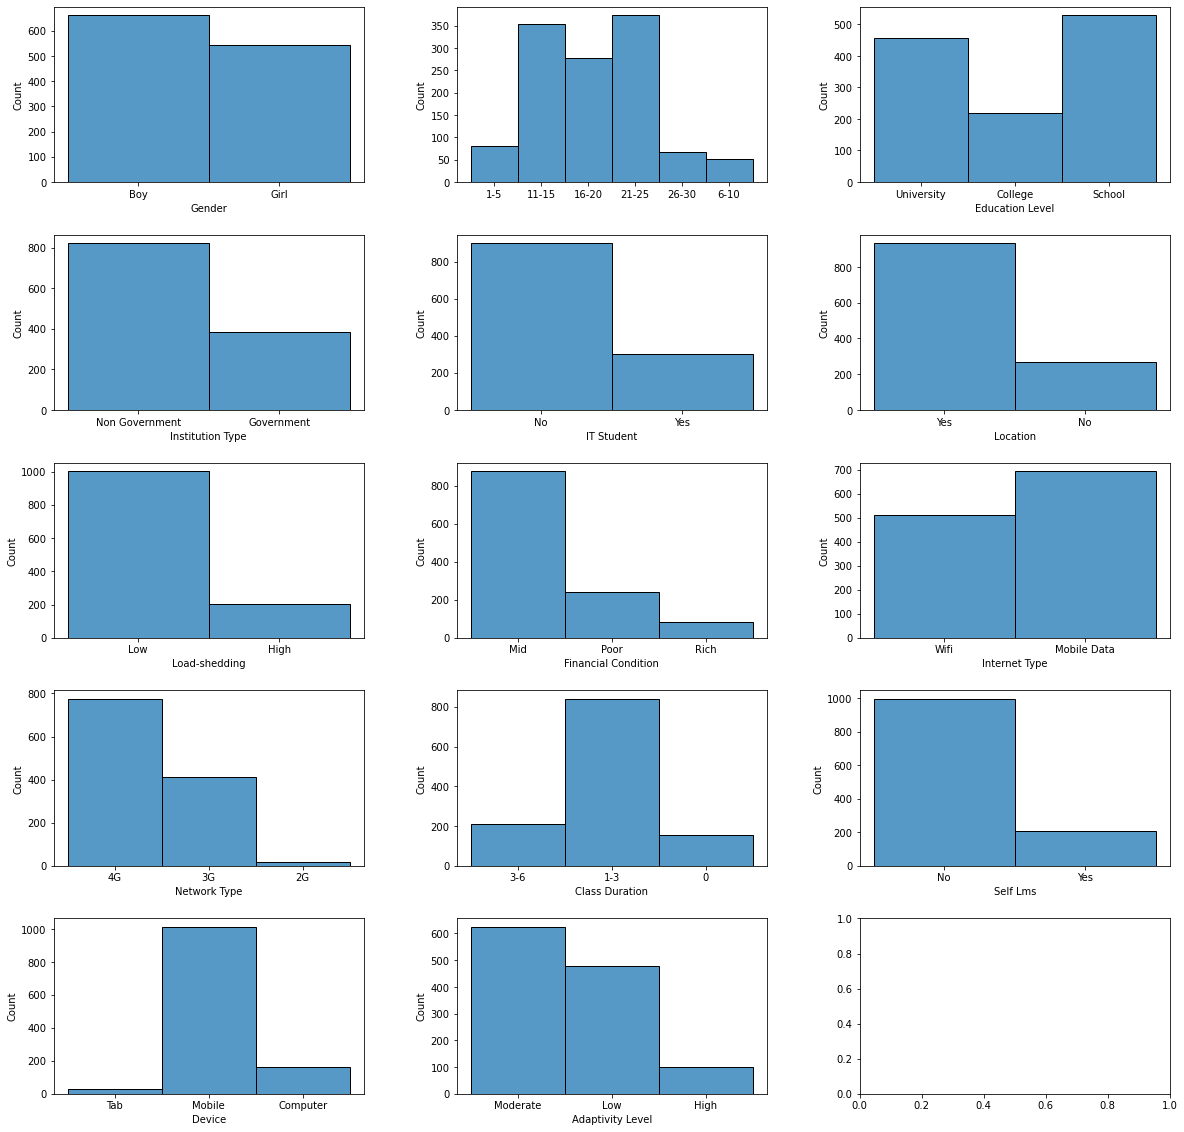

In [29]:
f, axes = plt.subplots(5,3)
f.set_size_inches((20,20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
sns.histplot(data.Gender, ax=axes[0,0])
sns.histplot(sorted(data.Age), ax=axes[0,1])
sns.histplot(data['Education Level'], ax=axes[0,2])
sns.histplot(data['Institution Type'], ax=axes[1,0])
sns.histplot(data['IT Student'], ax=axes[1,1])
sns.histplot(data['Location'], ax=axes[1,2])
sns.histplot(data['Load-shedding'], ax=axes[2,0])
sns.histplot(data['Financial Condition'], ax=axes[2,1])
sns.histplot(data['Internet Type'], ax=axes[2,2])
sns.histplot(data['Network Type'], ax=axes[3,0])
sns.histplot(data['Class Duration'], ax=axes[3,1])
sns.histplot(data['Self Lms'], ax=axes[3,2])
sns.histplot(data['Device'], ax=axes[4,0])
sns.histplot(data['Adaptivity Level'], ax=axes[4,1])
plt.show()

In [40]:
data['Adaptivity Level'].value_counts()

Moderate    625
Low         480
High        100
Name: Adaptivity Level, dtype: int64

학습에 사용되는 feature들 중에서는 성별과 인터넷 타입을 제외하고는 대부분 분포가 한쪽으로 치워쳐져 있는 것을 확인 할 수 있다.
또한 적응력을 보게되면 Moderate가 제일 높으며 High는 Moderate의 1/6배 정도 되는 것을 확인 할 수 있다. 이를 통해 class imbalance가 존재한다는 것을 확인 할 수 있다.

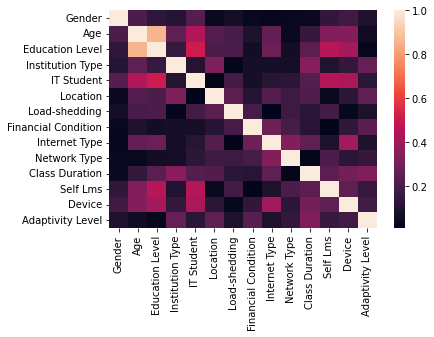

In [50]:
sns.heatmap(abs(Full_data.corr()))
plt.show()

위 heatmap은 데이터의 각 Feature간의 상관계수를 보여준다.
적응력과 나이, 학습 수준은 상관계수가 낮지만 다른 feature들과 상관계수가 낮지 않아 제외시키지 않았다.
또한 나이와 학습 수준은 매우 상관계수가 높은 것을 확인 할 수 있다.

# 모델 정의 및 Grid Search로 Setting 찾기

In [8]:
model = XGBClassifier(objective='multi:softmax')
param_grid = {'n_estimators': [100],
             'max_depth': [6,7,8,9,10],
             'learning_rate': [0.002],
             'colsample_bytree': [0.5,0.8],
             'gamma': [1,2,3],
             'min_child_weight': [1,2,3],
             'subsample': [0.8,1]}
np.random.seed(42)
cv = KFold(n_splits=4, random_state=42, shuffle=True)

In [9]:
tuned_model = GridSearchCV(model, param_grid=param_grid, cv=cv,scoring='accuracy', n_jobs=8)
tuned_model.fit(X_data.values, Y_data.values)
print('final params ', tuned_model.best_params_)
print('best score ', tuned_model.best_score_)

final params  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.002, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
best score  0.8306940441354426


# 최적의 Setting으로 모델 학습

In [16]:
model = tuned_model.best_estimator_
pred_Y = np.zeros([X_data.shape[0]])
model.fit(train_X, train_Y)
prediction = model.predict(valid_X)
print('Accuracy:',sum(prediction==valid_Y)/len(valid_Y))

Accuracy: 0.81


# 모델 저장

In [7]:
file_name = 'model'
model.fit(X_data, Y_data)
pickle.dump(model, open(file_name, 'wb'))